In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from numpy import exp
from scipy import ndimage
from func import *
from astropy.table import Table, hstack
import os
import glob
from astropy.table import Table, vstack, join
import pandas as pd
from shutil import copyfile
from scipy.optimize import leastsq
from cosmocalc import dist
from pprint import pprint


In [2]:
def flux_data_err(obj,destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/MUSE"):
    hdu = fits.open('%s/Flux Maps/%s/9_arcsec_subcube_par_%s.fits'%(destination_path_cube,obj,obj))
    (OIII_nr,OIII_br,Hb1_blr_br,Hb2_blr_br) = (hdu[2].data,hdu[3].data,hdu[5].data,hdu[6].data)
    hdu.close()
    
    hdu = fits.open('%s/Flux Maps/%s/9_arcsec_subcube_par_err_%s.fits'%(destination_path_cube,obj,obj))
    (OIII_nr_err,OIII_br_err,Hb1_blr_br_err,Hb2_blr_br_err) = (hdu[2].data,hdu[3].data,hdu[5].data,hdu[6].data)
    hdu.close()
    
    hdu = fits.open('%s/%s/%s_9_arcsec_empirical_factor_subcube.fits'%(destination_path_cube,obj,obj))
    central_tab = hdu[1].data
    central_columns = hdu[1].header
    (emp_Hb1,emp_Hb2) = (central_tab.field('emp_fact_Hb1')[0],central_tab.field('emp_fact_Hb2')[0])
    hdu.close()
    
    (amp_OIII_nr,amp_OIII_br,amp_Hb1_blr_br,amp_Hb2_blr_br) = (np.max(OIII_nr),np.max(OIII_br),np.max(Hb1_blr_br),np.max(Hb2_blr_br))
    if amp_Hb1_blr_br > amp_Hb2_blr_br:
        (Hb_blr_br,amp_Hb_blr_br,Hb_blr_err,emp_Hb_blr) = (Hb1_blr_br,amp_Hb1_blr_br,Hb1_blr_br_err,emp_Hb1)
    else:
        (Hb_blr_br,amp_Hb_blr_br,Hb_blr_err,emp_Hb_blr) = (Hb2_blr_br,amp_Hb2_blr_br,Hb2_blr_br_err,emp_Hb2)
    print (emp_Hb_blr)
    (blr_err_final,wing_err_final,core_err_final) = (emp_Hb_blr*Hb_blr_err,emp_Hb_blr*OIII_br_err,OIII_nr_err)
    return Hb_blr_br,OIII_br,OIII_nr,amp_Hb_blr_br,amp_OIII_br,amp_OIII_nr,blr_err_final,wing_err_final,core_err_final
    

In [3]:
def remove_bad_pixel(data,err):
    data[data == 0.01] = 0
    err[err < 10**(-7)] =10**(10)  
    return data,err

In [4]:
def ellip_moffat2D(p,xy,data,error):
    xy=(x,y)
    [amp, x0, y0, A, B, C, alpha] = p 
    g = amp*((1.0+A*(x-x0)**2+B*(y-y0)**2+C*(x-x0)*(y-y0))**(-alpha))
    h = (data - g)/error
    return h.ravel()

def ellip_moffat2D_fixkin(p,xy,data,error,fixed_param):
    [A,B,C,alpha] = fixed_param
    xy=(x,y)
    [amp, x0, y0] = p    
    g = amp*((1.0+(A*((x-x0)**2))+(B*((y-y0)**2))+(C*(x-x0)*(y-y0)))**(-alpha))
    h = (data - g)/error
    return h.ravel()

In [15]:
def elliptical_moffat_fit(x_BH,y_BH,data,error,box_size,amp,x0,y0,muse_sampling_size,fix_par,MC_loops=100):
    y, x = np.mgrid[:box_size, :box_size]
    xy=(x,y)
    
    if fix_par is None:
        p= [amp,x0,y0,0.1,0.1,-0.00008,3]
        popt,pcov = leastsq(ellip_moffat2D,x0=p,args=(xy,data,error),maxfev = 10000000)
        [amp_out,x0_out,y0_out,A_out,B_out,C_out,alpha_out]= popt
        theta_out = 0.5*np.arctan(C_out/(A_out - B_out))
        a_out = np.sqrt(2/(A_out + B_out + np.sqrt(C_out**2 +(A_out - B_out)**2)))
        b_out = np.sqrt(2/(A_out + B_out - np.sqrt(C_out**2 +(A_out - B_out)**2)))
        [fwhm1_out,fwhm2_out] = [2*a_out*np.sqrt(2**(1/alpha_out)-1),2*b_out*np.sqrt(2**(1/alpha_out)-1)]
        e_out = np.sqrt(1-((fwhm1_out**2)/(fwhm2_out**2)))
        par = [amp_out,x0_out,y0_out,A_out,B_out,C_out,alpha_out,a_out,b_out,theta_out,fwhm1_out,fwhm2_out,e_out]
        mod_rav = data.ravel() - ellip_moffat2D(popt,xy,data,error)*error.ravel()
    else:
        p= [amp,x0,y0]
        popt,pcov = leastsq(ellip_moffat2D_fixkin,x0=p,args=(xy,data,error,fix_par),maxfev = 10000000)
        [amp_out,x0_out,y0_out]= popt
        par = popt
        mod_rav = data.ravel() - ellip_moffat2D_fixkin(popt,xy,data,error,fix_par)*error.ravel()
    model = mod_rav.reshape(box_size,box_size)
    box_size = np.shape(data)[0]
    x, y = np.mgrid[:box_size, :box_size]
    radius = 4
    [x1,y1] = ndimage.measurements.maximum_position(data) # Define the PSF center
    small_data = data[(x-x1)**2 + (y-y1)**2 <= radius**2]
    small_model = model[(x-x1)**2 + (y-y1)**2 <= radius**2]
    
    ratio_flux = np.sum(small_data)/np.sum(small_model)
    
    full_par = np.append(par,ratio_flux)
    residual = data-model
    res = (residual/error)
    
    ratio_MC = np.zeros((1,MC_loops))
    parameters_MC = np.zeros((len(par),MC_loops))
    for l in range(MC_loops):
        iteration_data = np.random.normal(data,error) 
        if fix_par is None:
            p= [amp,x0,y0,0.1,0.1,-0.00008,3]
            popt_MC,pcov_MC = leastsq(ellip_moffat2D,x0=p,args=(xy,iteration_data,error),maxfev = 10000000)
            [amp_MC,x0_MC,y0_MC,A_MC,B_MC,C_MC,alpha_MC]= popt_MC
            theta_MC = 0.5*np.arctan(C_MC/(A_MC - B_MC))
            a_MC = np.sqrt(2/(A_MC + B_MC + np.sqrt(C_MC**2 +(A_MC - B_MC)**2)))
            b_MC = np.sqrt(2/(A_MC + B_MC - np.sqrt(C_MC**2 +(A_MC - B_MC)**2)))
            [fwhm1_MC,fwhm2_MC] = [2*a_MC*np.sqrt(2**(1/alpha_MC)-1),2*b_MC*np.sqrt(2**(1/alpha_MC)-1)]
            e_MC = np.sqrt(1-((fwhm1_MC**2)/(fwhm2_MC**2)))
            par_MC = [amp_MC,x0_MC,y0_MC,A_MC,B_MC,C_MC,alpha_MC,a_MC,b_MC,theta_MC,fwhm1_MC,fwhm2_MC,e_MC]   
            mod_rav_MC = iteration_data.ravel() - ellip_moffat2D(popt_MC,xy,iteration_data,error)*error.ravel() 
            parameters_MC[:,l] = par_MC
        else:
            p= [amp,x0,y0]
            popt_MC,pcov_MC = leastsq(ellip_moffat2D_fixkin,x0=p,args=(xy,iteration_data,error,fix_par),maxfev = 10000000)
            [amp_MC,x0_out,y0_out]= popt_MC
            mod_rav_MC = iteration_data.ravel() - ellip_moffat2D_fixkin(popt_MC,xy,iteration_data,error,fix_par)*error.ravel()
            parameters_MC[:,l] = popt_MC   
        model_MC = mod_rav_MC.reshape(box_size,box_size)
        box_size = np.shape(data)[0]
        x, y = np.mgrid[:box_size, :box_size]
        radius = 4
        [x1,y1] = ndimage.measurements.maximum_position(iteration_data) # Define the PSF center
        small_data_MC = iteration_data[(x-x1)**2 + (y-y1)**2 <= radius**2]
        small_model_MC = model_MC[(x-x1)**2 + (y-y1)**2 <= radius**2]
        ratio_flux_MC = np.sum(small_data_MC)/np.sum(small_model_MC)
        if ratio_flux_MC < 0 or ratio_flux_MC > 2*ratio_flux:
            ratio_flux_MC = np.nan
        else:
            ratio_flux_MC = ratio_flux_MC
        ratio_MC[:,l] = ratio_flux_MC
        
    ratio_err = np.nanstd(ratio_MC,1)
    par_err = np.nanstd(parameters_MC,1) 
    parameters_err = np.append(par_err,ratio_err)

    return full_par,parameters_err,model,res

In [16]:
def moffat_table(full_data,full_error,D_A,D_L,muse_sampling_size,obj,destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/MUSE"):
    final_data = np.append(full_data,[D_A,D_L,muse_sampling_size])
    final_error = np.append(full_error,[0,0,0])
    column_names={'amp_Hb_blr':0,'x0_Hb_Blr':1,'y0_Hb_Blr':2,'A':3,'B':4,'C':5,'alpha':6,'a':7,'b':8,'theta':9,'fwhm1':10,'fwhm2':11,'e':12,'r_BLR':13,'amp_OIII_br':14,'x0_OIII_br':15,'y0_OIII_br':16,'r_wing':17,'amp_OIII_nr':18,'x0_OIII_nr':19,'y0_OIII_nr':20,'r_core':21,'D_A':22,'D_L':23,'sampling_size':24}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[final_data[column_names[key]]]))
        columns.append(fits.Column(name=key+'_err',format='E',array=[final_error[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s/%s/9_arcsec_moffat_table_%s.fits'%(destination_path_cube,obj,obj),overwrite=True)
    
def source_moffat_table(obj,destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/MUSE"):
    t1 = Table.read('%s/%s/source_%s.fits'%(destination_path_cube,obj,obj),format='fits')
    t2 = Table.read('%s/%s/9_arcsec_moffat_table_%s.fits'%(destination_path_cube,obj,obj),format='fits')
    new = hstack([t1, t2])
    new.write('%s/%s/%s_9_arcsec_moffat_table.fits'%(destination_path_cube,obj,obj),overwrite=True)


def maps(Hb_blr_br_data,OIII_br_data,OIII_nr_data,Hb_model,OIII_br_model,OIII_nr_model,Hb_res,OIII_br_res,OIII_nr_res,obj,destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/MUSE"):
    hdus=[]
    hdus.append(fits.PrimaryHDU())
    hdus.append(fits.ImageHDU(Hb_blr_br_data,name='Hb_blr_br_data'))
    hdus.append(fits.ImageHDU(OIII_br_data,name='OIII_br_data'))
    hdus.append(fits.ImageHDU(OIII_nr_data,name='OIII_nr_data'))
    hdus.append(fits.ImageHDU(Hb_model,name='Hb_blr_br_model'))
    hdus.append(fits.ImageHDU(OIII_br_model,name='OIII_br_model'))   
    hdus.append(fits.ImageHDU(OIII_nr_model,name='OIII_nr_model'))
    hdus.append(fits.ImageHDU(Hb_res,name='Hb_blr_br_res'))
    hdus.append(fits.ImageHDU(OIII_br_res,name='OIII_br_res'))
    hdus.append(fits.ImageHDU(OIII_nr_res,name='OIII_nr_res'))
    hdu = fits.HDUList(hdus)
    hdu.writeto('%s/%s/9_arcsec_maps_%s.fits'%(destination_path_cube,obj,obj),overwrite='True')

def fluxden_compare(obj,Hb_blr_br_data,OIII_br_data,Hb_model,OIII_br_model,Hb_blr_br_err,OIII_br_err,destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/MUSE"):
    f_blr_data = np.sum(Hb_blr_br_data)
    f_wing_data = np.sum(OIII_br_data)
    f_blr_model = np.sum(Hb_model)
    f_wing_model = np.sum(OIII_br_model)
    f_blr_err = np.sqrt(np.sum(Hb_blr_br_err**2))
    f_wing_err = np.sqrt(np.sum(OIII_br_err**2))
    tab_par = [f_blr_data,f_wing_data,f_blr_model,f_wing_model]
    tab_err = [f_blr_err,f_wing_err,0,0]
    column_names={'flux_blr_data':0,'flux_wing_data':1,'flux_blr_model':2,'flux_wing_model':3}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[tab_par[column_names[key]]]))
        columns.append(fits.Column(name=key+'_err',format='E',array=[tab_err[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s/%s/%s_9_arcsec_fluxden_HbOIII.fits'%(destination_path_cube,obj,obj),overwrite=True)
    
def fluxden_comp_table(obj,destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/MUSE"):
    t1 = Table.read('%s/%s/source_%s.fits'%(destination_path_cube,obj,obj),format='fits')
    t2 = Table.read('%s/%s/%s_9_arcsec_fluxden_HbOIII.fits'%(destination_path_cube,obj,obj),format='fits')
    new = hstack([t1, t2])
    new.write('%s/%s/%s_9_arcsec_fluxden_HbOIII.fits'%(destination_path_cube,obj,obj),overwrite=True)
    
def emp_table(obj,emp_blr,emp_wing,destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/MUSE"):
    popt = [emp_blr,emp_wing]
    column_names={'emp_fact_blr':0,'emp_fact_wing':1}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[popt[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s/%s/%s_9_arcsec_scaling_subcube.fits'%(destination_path_cube,obj,obj),overwrite=True)

def emp_fact_table(obj,destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/MUSE"):
    t1 = Table.read('%s/%s/source_%s.fits'%(destination_path_cube,obj,obj),format='fits')
    t2 = Table.read('%s/%s/%s_9_arcsec_scaling_subcube.fits'%(destination_path_cube,obj,obj),format='fits')
    new = hstack([t1, t2])
    new.write('%s/%s/%s_9_arcsec_scaling_subcube.fits'%(destination_path_cube,obj,obj),overwrite=True)

In [17]:
def algorithm_script(obj,z,destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/MUSE"):  
    print ('%s'%(obj))
    (Hb_blr_br_dat,OIII_br_dat,OIII_nr_dat,amp_Hb_blr_br,amp_OIII_br,amp_OIII_nr,Hb_blr_br_error,OIII_br_error,OIII_nr_error) = flux_data_err(obj)
    (Hb_blr_br_data,Hb_blr_br_err) = remove_bad_pixel(Hb_blr_br_dat,Hb_blr_br_error)
    (OIII_br_data,OIII_br_err) = remove_bad_pixel(OIII_br_dat,OIII_br_error)
    (OIII_nr_data,OIII_nr_err) = remove_bad_pixel(OIII_nr_dat,OIII_nr_error)  
    box_size = np.shape(Hb_blr_br_data)[0]
    (brightest_pixel_Hb_blr_br_x,brightest_pixel_Hb_blr_br_y,brightest_pixel_OIII_br_x,brightest_pixel_OIII_br_y,brightest_pixel_OIII_nr_x,brightest_pixel_OIII_nr_y) = brightest_pixel_flux_map(Hb_blr_br_data,OIII_br_data,OIII_nr_data) 
    (x_BH,y_BH) = (brightest_pixel_Hb_blr_br_x,brightest_pixel_Hb_blr_br_y)
    print (brightest_pixel_OIII_nr_x,brightest_pixel_OIII_nr_y)
    
    if box_size ==45:
        muse_sampling_size = 0.2
    else:
        muse_sampling_size = 0.4
  
    print (muse_sampling_size)
    (Hb_par,Hb_error,Hb_model,Hb_res) = elliptical_moffat_fit(x_BH,y_BH,Hb_blr_br_data,Hb_blr_br_err,box_size,amp_Hb_blr_br,brightest_pixel_Hb_blr_br_x,brightest_pixel_Hb_blr_br_y,muse_sampling_size,None,100)
    print (Hb_par,Hb_error)
    #print (red_chi_sq_Hb)
    fixed_param = [Hb_par[3],Hb_par[4],Hb_par[5],Hb_par[6]]
    (OIII_br_par,OIII_br_error,OIII_br_model,OIII_br_res) = elliptical_moffat_fit(x_BH,y_BH,OIII_br_data,OIII_br_err,box_size,amp_OIII_br,brightest_pixel_OIII_br_x,brightest_pixel_OIII_br_y,muse_sampling_size,fixed_param,100)   
    print (OIII_br_par,OIII_br_error)
    (OIII_nr_par,OIII_nr_error,OIII_nr_model,OIII_nr_res) = elliptical_moffat_fit(x_BH,y_BH,OIII_nr_data,OIII_nr_err,box_size,amp_OIII_nr,brightest_pixel_OIII_nr_x,brightest_pixel_OIII_nr_y,muse_sampling_size,fixed_param,100)   
    print (OIII_nr_par,OIII_nr_error)

    (D_A,D_L) = dist(z, H0=70, WM=.286)
    (full_data,full_error) = (np.append(Hb_par,[OIII_br_par,OIII_nr_par]),np.append(Hb_error,[OIII_br_error,OIII_nr_error]))
    moffat_table(full_data,full_error,D_A,D_L,muse_sampling_size,obj,destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/MUSE")
    maps(Hb_blr_br_data,OIII_br_data,OIII_nr_data,Hb_model,OIII_br_model,OIII_nr_model,Hb_res,OIII_br_res,OIII_nr_res,obj)
    fluxden_compare(obj,Hb_blr_br_data,OIII_br_data,Hb_model,OIII_br_model,Hb_blr_br_err,OIII_br_err)
    source_moffat_table(obj)
        
    plt.imshow(Hb_blr_br_data,origin='lower')
    plt.plot(Hb_par[1],Hb_par[2],'kx')
    plt.show()
    plt.imshow(Hb_model,origin='lower')
    plt.plot(Hb_par[1],Hb_par[2],'kx')
    plt.show()
    plt.imshow(OIII_br_data,origin='lower')
    plt.plot(OIII_br_par[1],OIII_br_par[2],'bx')
    plt.show()
    plt.imshow(OIII_br_model,origin='lower')
    plt.plot(OIII_br_par[1],OIII_br_par[2],'bx')
    plt.show()
    plt.imshow(OIII_nr_data,origin='lower')
    plt.plot(OIII_nr_par[1],OIII_nr_par[2],'gx')
    plt.show()
    plt.imshow(OIII_nr_model,origin='lower')
    plt.plot(OIII_nr_par[1],OIII_nr_par[2],'gx')
    plt.show()
    

1.2495849
HE0021-1810
1.2495849
22 22
0.2
[ 2.55837387e-02  2.19115104e+01  2.25162231e+01  3.36797853e-02
  3.69143816e-02  3.64036208e-03  3.70515208e+00  5.14807912e+00
  5.51634929e+00 -4.22175306e-01  4.66995893e+00  5.00402655e+00
  3.59252918e-01  1.03070909e+00] [0.00268149 0.10416771 0.08871525 0.01234606 0.0138156  0.00387786
 1.09381263 1.06467498 1.14840917 0.40043962 0.3239605  0.34446634
 0.0985252  0.02542474]
[ 0.23324406 21.99236223 22.34122318  1.01431449] [0.00129993 0.01399746 0.01339841 0.00339523]


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


[ 0.36332332 22.04131391 22.34318131  1.00886407] [0.00189207 0.01079251 0.01230124        nan]


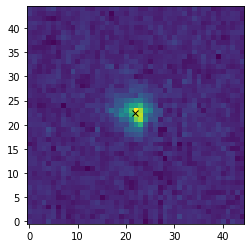

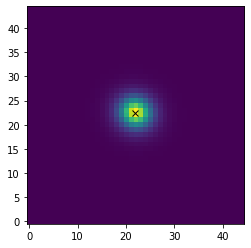

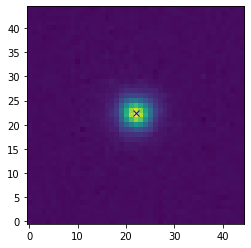

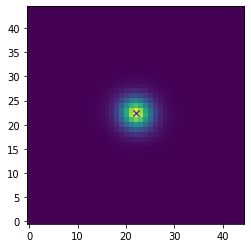

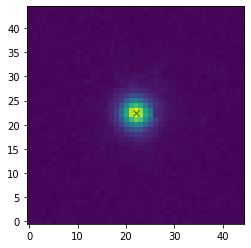

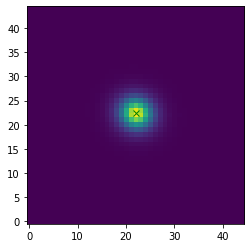

In [20]:
z = {"HE0021-1810":0.05352}


objs = z.keys()

for obj in objs:
    (Hb_blr_br_data,OIII_br_data,OIII_nr_data,amp_Hb_blr_br,amp_OIII_br,amp_OIII_nr,Hb_blr_br_err,OIII_br_err,OIII_nr_err) = flux_data_err(obj)
    box_size = np.shape(Hb_blr_br_data)[1]  
    y, x = np.mgrid[:box_size, :box_size]
    xy=(x,y)
    algorithm_script(obj,z[obj])

1.5935528
HE0021-1819
1.5935528
22 22
0.2
[ 6.37272579e-02  2.21518271e+01  2.21893724e+01  9.38226766e-02
  9.77912232e-02 -1.31059412e-02  2.32426241e+00  3.12113516e+00
  3.35275843e+00  6.38383991e-01  3.67956007e+00  3.95262474e+00
  3.65234347e-01  1.00491229e+00] [0.00058138 0.01225841 0.013326   0.00388787 0.00412466 0.00159016
 0.05781711 0.06549195 0.07241441 0.04604201 0.03110593 0.03381547
 0.0188272  0.00210108]
[ 0.37110411 22.03060928 22.36204441  1.01086977] [0.00120702 0.00738487 0.00796448 0.00191477]
[ 1.94631835 22.13051206 22.09156413  0.96935258] [0.00201448 0.00232096 0.00311249 0.00064826]


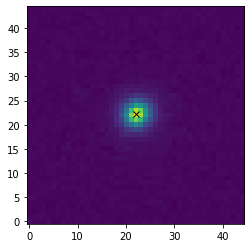

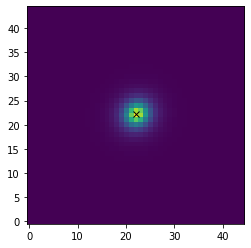

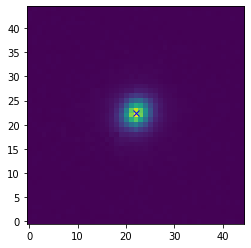

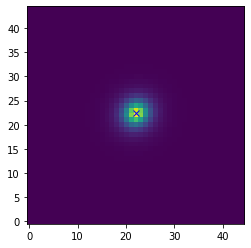

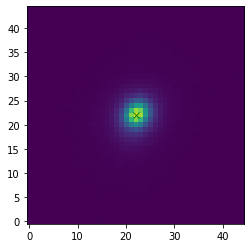

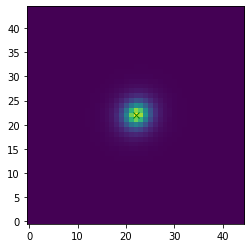

1.5767037
HE0040-1105
1.5767037
21 22
0.2
[ 4.00394899e-01  2.15230087e+01  2.21713217e+01  8.81143501e-02
  9.85693015e-02 -3.46362038e-03  2.63037616e+00  3.18064001e+00
  3.37416501e+00  1.59955195e-01  3.49290814e+00  3.70543300e+00
  3.33796756e-01  1.00389159e+00] [0.00168581 0.00535109 0.0052789  0.00149426 0.00166224 0.00068489
 0.02533457 0.02693659 0.02856946 0.03067667 0.01289259 0.01381519
 0.00913437 0.00105266]
[ 0.66572802 22.0706965  22.04878999  0.98789635] [0.00234891 0.00896585 0.00769328 0.00312068]
[ 4.11731192 21.36721451 22.34765719  0.84629265] [0.00488054 0.00259992 0.00301542 0.00065433]


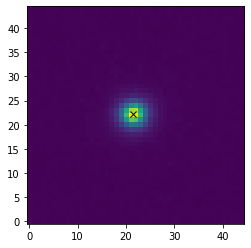

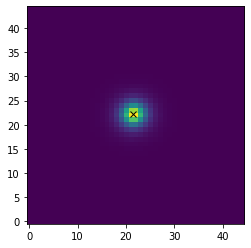

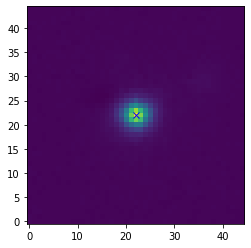

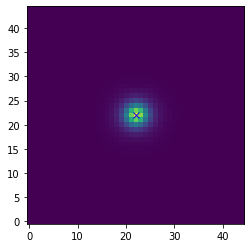

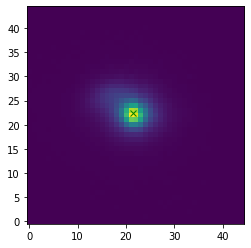

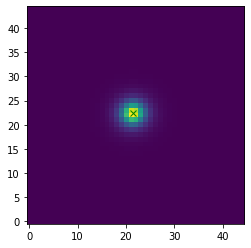

1.6356565
HE0108-4743
1.6356565
21 21
0.2


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.


[ 2.29604300e-01  2.22776809e+01  2.12609082e+01  2.72729752e-02
  2.91059686e-02  9.32829528e-04  2.26764003e+00  5.85027205e+00
  6.06772889e+00 -2.35375267e-01  6.99622918e+00  7.25628169e+00
  2.65315166e-01  9.92009872e-01] [0.0039166  0.04189714 0.03567494 0.00164968 0.00173871 0.00071665
 0.07264294 0.17121106 0.1884247  0.19820446 0.09157758 0.10809311
 0.04740901 0.00774655]
[ 0.53813636 21.61033069 21.43408511  0.84221494] [0.00355667 0.03682708 0.04418698 0.00828696]
[ 1.06107862 20.28843031 21.44342865  0.87069371] [0.00322765 0.01811697 0.01578497 0.00979896]


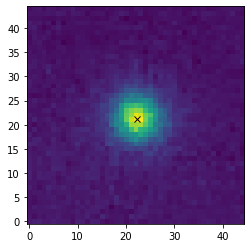

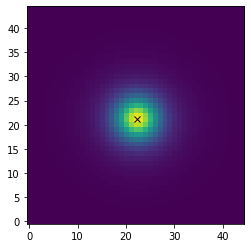

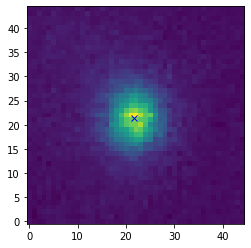

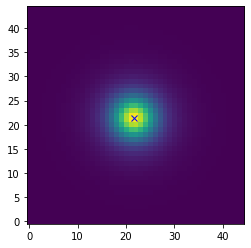

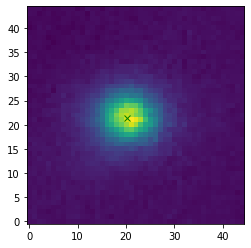

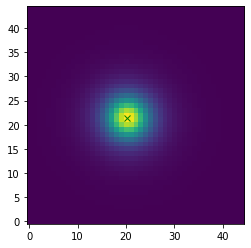

1.6499506
HE0114-0015
1.6499506
22 22
0.2
[ 1.20675338e-01  2.17941095e+01  2.15175652e+01  1.27340657e-01
  1.39657181e-01  5.29558960e-04  2.50167141e+00  2.67583615e+00
  2.80237441e+00 -2.14846735e-02  3.02387721e+00  3.16687406e+00
  2.97101009e-01  1.00491695e+00] [0.00216638 0.01782059 0.0181132  0.01048889 0.01135988 0.00418285
 0.11955832 0.10829019 0.11655059 0.18472561 0.0477361  0.05470414
 0.04092112 0.00608998]
[ 0.05397207 21.8883899  21.89719171  0.98502725] [0.00238801 0.06341071 0.09215991 0.02224472]
[ 0.56516003 21.84658961 21.70243256  0.96307784] [0.00242444 0.00706504 0.00890488 0.0026658 ]


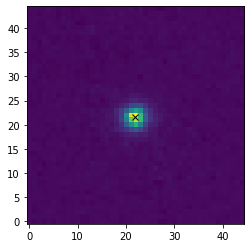

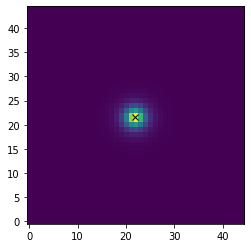

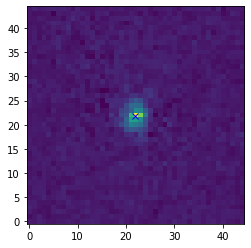

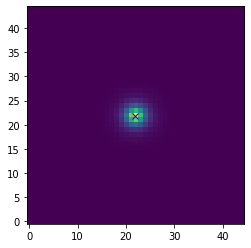

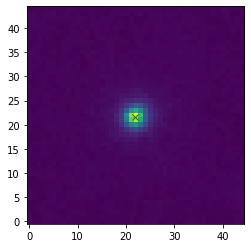

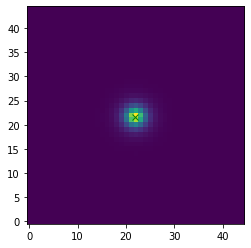

1.6265484
HE0119-0118
1.6265484
22 22
0.2
[ 3.27869797e-01  2.17630196e+01  2.17868988e+01  1.16746438e-01
  1.35975743e-01  3.78388736e-03  2.02927278e+00  2.71003585e+00
  2.92901363e+00 -9.71473630e-02  3.45850255e+00  3.73795835e+00
  3.79386250e-01  1.00595681e+00] [0.00646072 0.02451646 0.01940927 0.00586482 0.00660444 0.00275894
 0.04499267 0.06623811 0.07510897 0.07088941 0.04798944 0.05343946
 0.02605561 0.00801282]
[ 1.84112387 21.55577841 21.63515289  1.05964759] [0.00489385 0.00584954 0.00607278 0.00301158]
[ 2.72458684 21.70923281 21.64165628  1.03982439] [0.00459622 0.00369742 0.00397539 0.00213974]


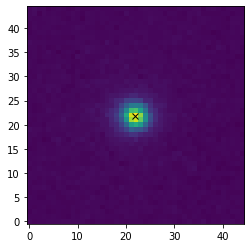

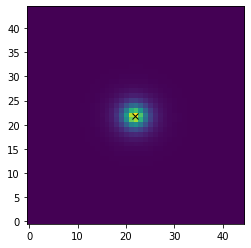

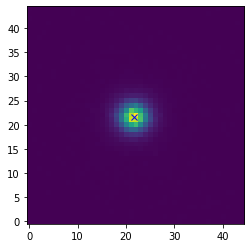

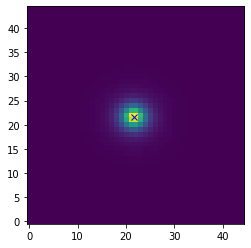

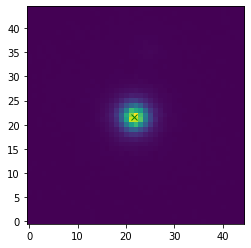

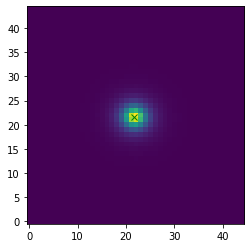

1.4443191
HE0212-0059
1.4443191
22 22
0.2
[2.92767233e-01 2.23032440e+01 2.16388642e+01 1.92147879e-01
 1.89302788e-01 6.35725022e-04 1.61476440e+00 2.28109074e+00
 2.29859120e+00 1.09917552e-01 3.34042077e+00 3.36604837e+00
 1.23163082e-01 1.01452423e+00] [0.00589209 0.01701081 0.01660881 0.00503908 0.00506774 0.00293932
 0.01013486 0.03044234 0.02949554 0.39176057 0.0348167  0.03366986
 0.04016089 0.00378908]
[ 0.20551632 22.45598534 23.38920859  1.38972814] [0.00445943 0.02943397 0.06913756 0.07118883]
[ 2.62916757 22.3020543  21.58422114  1.01562835] [0.00311849 0.00364405 0.00364982 0.00335542]


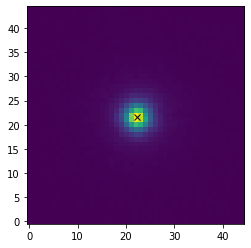

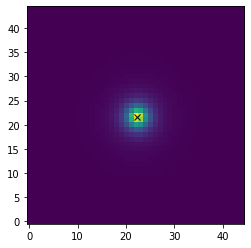

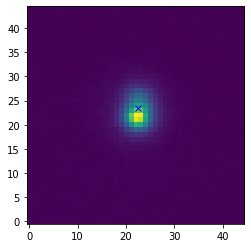

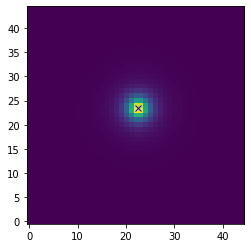

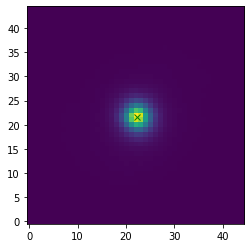

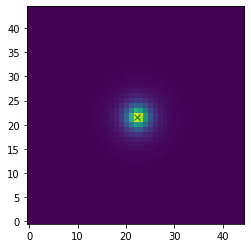

1.6447451
HE0224-2834
1.6447451
21 23
0.2


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.


[ 6.44080729e-02  2.17936625e+01  2.21415097e+01  1.49009330e-02
  1.51499436e-02 -3.17716150e-04  3.04378868e+00  8.10380394e+00
  8.21340259e+00  4.53020879e-01  8.19630951e+00  8.30715923e+00
  1.62817989e-01  1.00937558e+00] [3.43752217e-04 1.09054471e-02 1.18030418e-02 3.81338448e-04
 3.87208545e-04 9.57570143e-05 4.95068348e-02 1.02391454e-01
 1.06667752e-01 2.04062760e-01 3.62492939e-02 3.74105885e-02
 2.01505214e-02 4.08689107e-03]
[ 0.1820432  21.86967972 22.03933167  0.98529876] [0.00082412 0.02194123 0.01766313 0.00871576]
[ 0.54895642 20.13833681 22.80512736  0.81167825] [0.00080803 0.0116264  0.00888078 0.02616764]


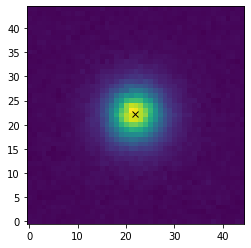

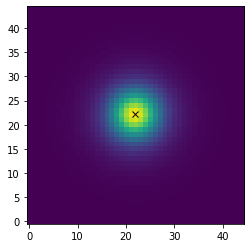

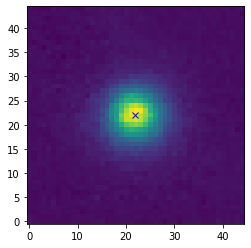

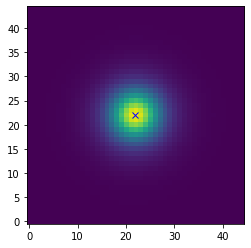

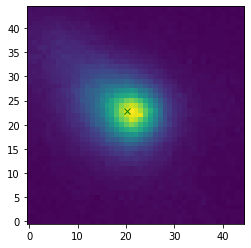

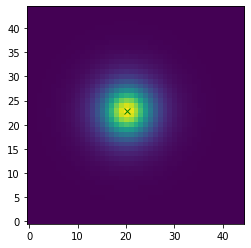

1.6146098
HE0227-0913
1.6146098
21 22
0.2
[ 1.31549298e+00  2.15668160e+01  2.14859516e+01  3.98750142e-02
  4.09743536e-02 -1.08512862e-03  2.25881649e+00  4.92682420e+00
  5.02187133e+00  3.89446457e-01  5.90524418e+00  6.01916676e+00
  1.93636400e-01  9.99041433e-01] [0.00437885 0.00662317 0.00594215 0.00040933 0.00041801 0.00021322
 0.01068275 0.02580731 0.02538487 0.06266669 0.01693953 0.01632412
 0.01179856 0.00183026]
[ 0.11556952 21.71713042 21.67134525  1.05630194] [0.00084891 0.02893459 0.02511209 0.00673938]
[ 1.13113531 21.58403619 21.66030372  0.96967217] [0.00089201 0.00314302 0.0026946  0.00099914]


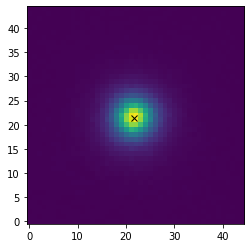

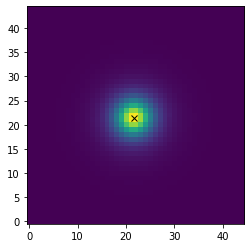

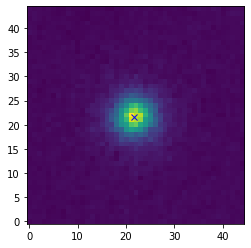

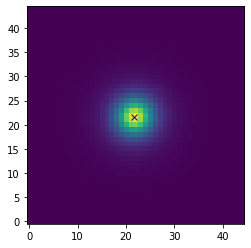

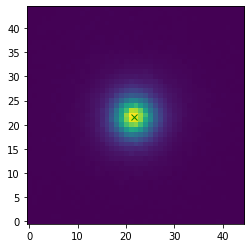

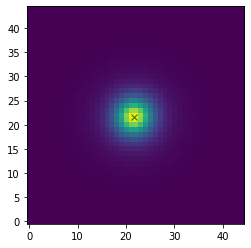

1.6279633
HE0232-0900
1.6279633
22 22
0.2
[ 1.59757185e+00  2.20781597e+01  2.24400025e+01  3.45048560e-02
  3.61971444e-02  7.61406116e-04  2.48928296e+00  5.25016893e+00
  5.38982491e+00 -2.11396581e-01  5.94993948e+00  6.10820955e+00
  2.26165208e-01  1.00102522e+00] [5.04919120e-03 4.48687616e-03 3.98144060e-03 2.57189472e-04
 2.77599744e-04 9.95604405e-05 8.67464536e-03 2.01442473e-02
 2.01754532e-02 2.65533438e-02 1.21806125e-02 1.20711009e-02
 5.58316368e-03 1.00489838e-03]
[ 4.25579877 21.36507369 22.22988431  0.86021404] [0.00850887 0.00834744 0.00646809 0.00756114]
[10.31950157 21.96983675 20.90760893  0.81833433] [0.00975771 0.00280777 0.00421603 0.00823634]


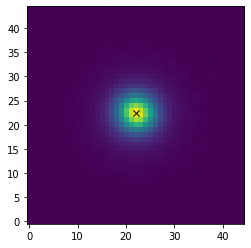

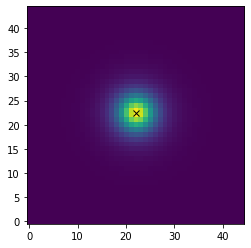

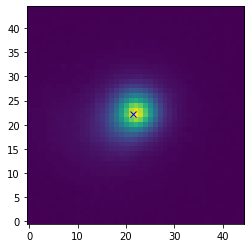

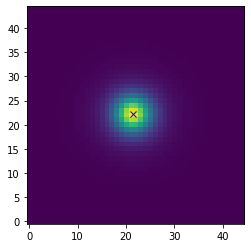

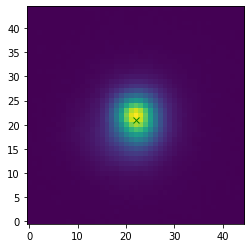

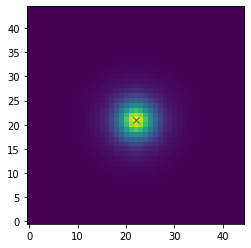

1.3951703
HE0253-1641
1.3951703
22 22
0.2
[5.50881651e-01 2.18449078e+01 2.20585860e+01 6.23679260e-02
 6.06355841e-02 4.85083580e-03 2.39862146e+00 3.95046524e+00
 4.11950816e+00 6.13895283e-01 4.57341345e+00 4.76911271e+00
 2.83523573e-01 1.00080876e+00] [0.00859989 0.01619456 0.01654674 0.00252162 0.00245741 0.00086185
 0.04367182 0.07860355 0.08329472 0.15482806 0.04828242 0.05195742
 0.02286017 0.00310074]
[ 1.34250753 21.67569896 22.09653649  0.99991465] [0.00328039 0.006133   0.00630151 0.00243209]
[ 4.2411845  21.55230303 21.55386066  0.95992237] [0.00465232 0.00327597 0.00316964 0.00125772]


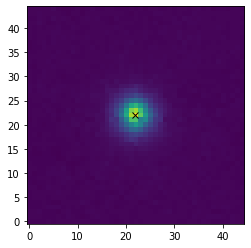

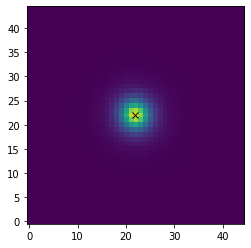

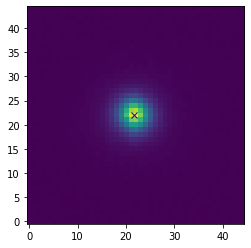

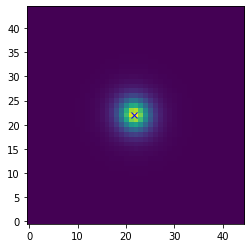

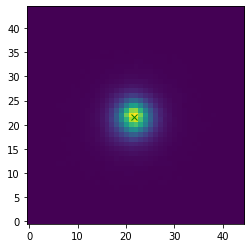

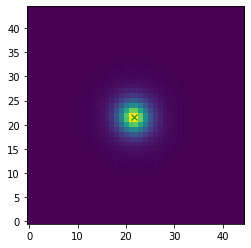

1.3926791
HE0345+0056
1.3926791
21 22
0.2
[ 5.50541224e+00  2.15123739e+01  2.14473394e+01  6.62374293e-02
  6.78927327e-02  1.33723035e-03  2.31027815e+00  3.83119095e+00
  3.89246226e+00 -3.39753437e-01  4.53245303e+00  4.60493945e+00
  1.76732141e-01  1.01019991e+00] [0.03104373 0.00563824 0.00521814 0.00063826 0.00061031 0.00029485
 0.00808574 0.01747388 0.01855119 0.06686242 0.01267103 0.01409571
 0.01022982 0.00187676]
[ 2.26511373 21.5391752  21.39442701  1.04380303] [0.00414432 0.00558361 0.00478115 0.00256413]
[ 4.12728901 21.50551727 21.30298897  0.89748248] [0.00520131 0.00389686 0.00364715 0.00225086]


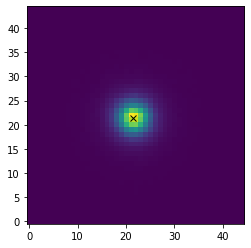

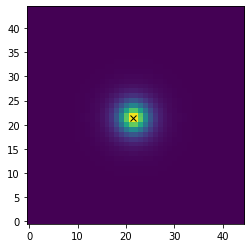

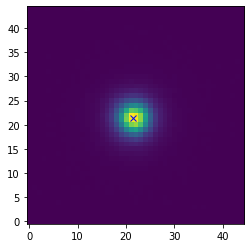

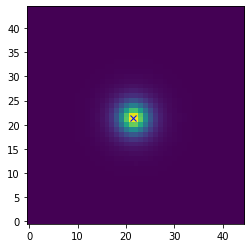

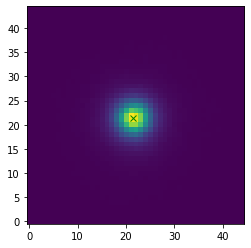

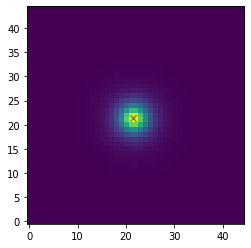

1.3910508
HE0351+0240
1.3910508
22 22
0.2
[ 7.84530700e-01  2.19481608e+01  2.17297873e+01  8.36265761e-02
  7.67601771e-02 -2.27248840e-03  2.62878442e+00  3.45424244e+00
  3.61368855e+00 -1.59805531e-01  3.79467853e+00  3.96983901e+00
  2.93766588e-01  1.00123317e+00] [0.00394417 0.00523276 0.00579553 0.00159932 0.00148878 0.00051801
 0.02975766 0.03291651 0.03479026 0.03622451 0.0145416  0.01622951
 0.01083658 0.00103169]
[ 0.50537683 21.84208159 21.69207812  0.88574238] [0.00428889 0.02502867 0.02529496 0.00673117]
[ 8.76699393 21.96445073 21.66651895  0.96250757] [0.00881847 0.00231376 0.00242323 0.00057125]


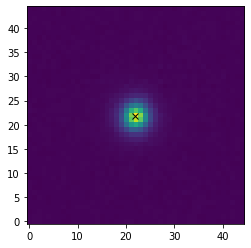

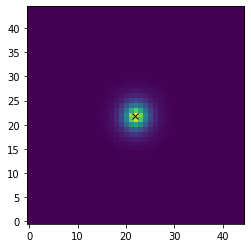

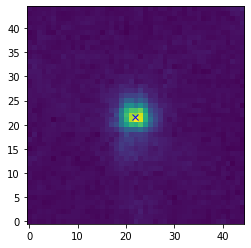

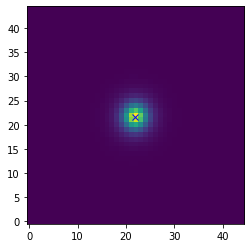

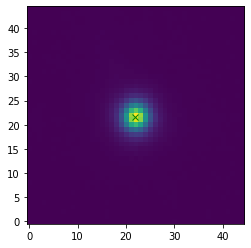

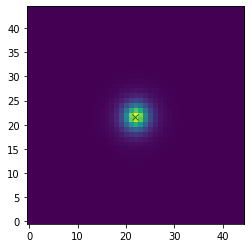

1.4130688
HE0412-0803
1.4130688
22 22
0.2
[ 1.70308524e+00  2.19737119e+01  2.18663760e+01  9.04445240e-02
  9.36215287e-02  7.97708493e-03  2.40373367e+00  3.22201577e+00
  3.37599415e+00 -5.95892673e-01  3.72552628e+00  3.90356715e+00
  2.98562089e-01  9.99554768e-01] [0.0058178  0.00211462 0.00243693 0.00062123 0.00066326 0.00022728
 0.00711615 0.01142758 0.01156623 0.0127496  0.00769256 0.00748166
 0.00364229 0.0010272 ]
[ 6.3955631  22.14408273 21.87852077  0.89681807] [0.00905386 0.00326832 0.003532   0.00233379]
[68.30665924 22.25026899 22.00383249  0.50660015] [0.02695595 0.00101524 0.00131587 0.00071126]


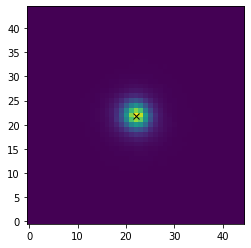

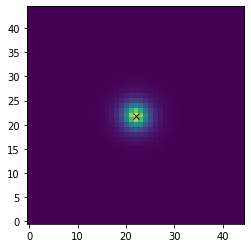

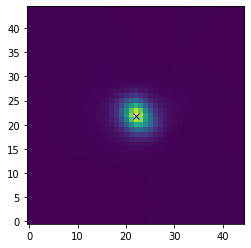

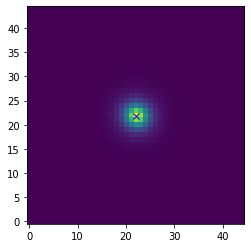

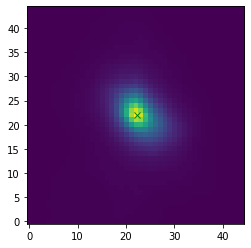

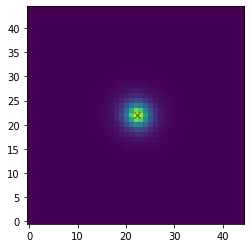

1.3098165
HE0429-0247
1.3098165
22 22
0.2
[ 4.35348150e-01  2.23886971e+01  2.18637550e+01  6.57740642e-02
  6.19067752e-02 -8.74516674e-05  2.19455450e+00  3.89915975e+00
  4.01913545e+00 -1.13046586e-02  4.75264383e+00  4.89888092e+00
  2.42510112e-01  1.01265481e+00] [0.00474404 0.01412617 0.01427007 0.00183884 0.00177316 0.00074128
 0.02868703 0.0542354  0.05717897 0.09226018 0.03568924 0.03896575
 0.02406674 0.00285602]
[ 0.53083742 22.63944015 21.83508342  1.05501523] [0.00183956 0.01161881 0.01042687 0.00331514]
[ 2.63768887 21.9437318  21.97791579  0.88182035] [0.00271115 0.00365564 0.00383866 0.00086512]


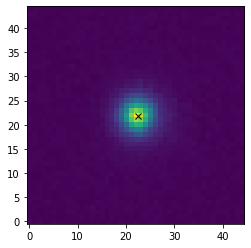

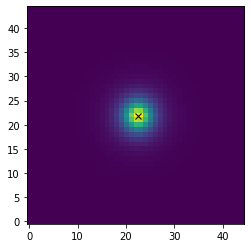

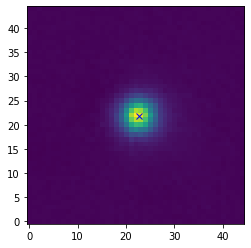

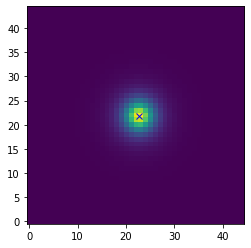

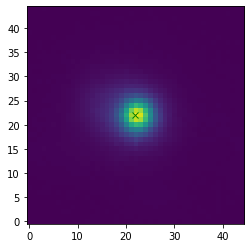

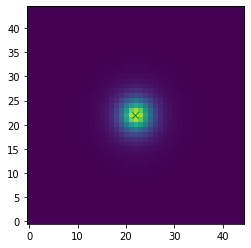

1.4312612
HE0433-1028
1.4312612
22 23
0.2
[ 3.45025521e+00  2.22181509e+01  2.24989536e+01  1.70256999e-01
  1.69770897e-01 -2.28789866e-03  2.11602692e+00  2.41695817e+00
  2.43364142e+00 -6.80721430e-01  3.00944716e+00  3.03022010e+00
  1.16891077e-01  9.93035490e-01] [0.03853426 0.0062975  0.00613135 0.00340883 0.00357426 0.00118223
 0.01522729 0.02463175 0.0252932  0.58079504 0.01930011 0.01977531
 0.0289802  0.00250304]
[ 6.93707529 22.28783317 22.43002894  1.00234232] [0.01097092 0.00318837 0.00279433 0.00224282]
[ 7.00935083 22.23899941 22.62046496  0.94135108] [0.01044346 0.00328605 0.00338023 0.00273902]


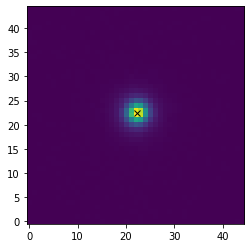

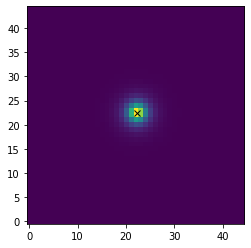

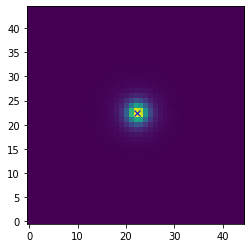

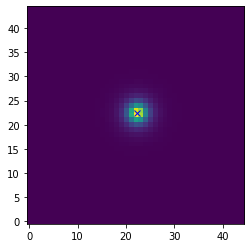

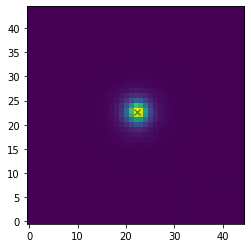

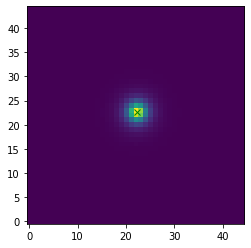

1.5838728
HE0853+0102
1.5838728
22 22
0.2
[ 1.30912120e-01  2.22329979e+01  2.15197855e+01  1.60251222e-01
  1.56179362e-01 -5.12892808e-03  2.14097520e+00  2.48844267e+00
  2.54048672e+00 -4.49892801e-01  3.07725236e+00  3.14161095e+00
  2.01375381e-01  1.00613989e+00] [0.00207886 0.01379135 0.01435203 0.00908786 0.00900198 0.00347744
 0.0621159  0.07193241 0.07071649 0.37864727 0.04331268 0.04062864
 0.04469762 0.00324331]
[ 0.23570526 22.18775248 21.48139655  1.00192315] [0.00170863 0.01415581 0.01755594 0.00364331]
[ 0.85271965 22.38098212 21.71250082  0.96706018] [0.00212554 0.00465776 0.00553886 0.00121941]


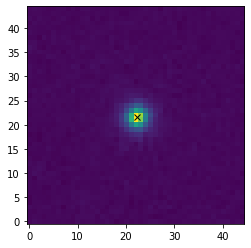

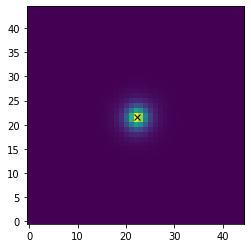

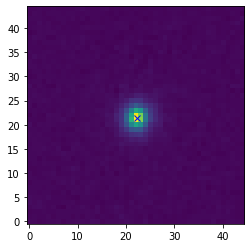

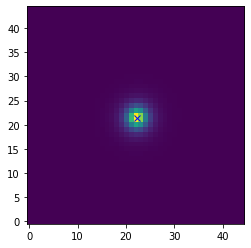

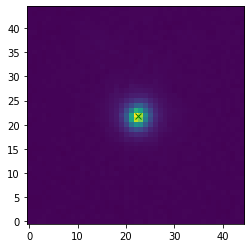

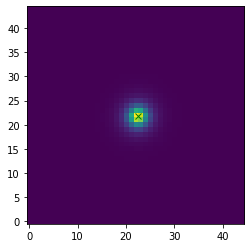

2.1618216
HE0934+0119
2.1618216
22 22
0.2
[ 9.04187431e-01  2.18180317e+01  2.16035113e+01  1.04546717e-01
  1.04592083e-01 -4.47493756e-04  2.24997271e+00  3.08909441e+00
  3.09574518e+00  7.34881849e-01  3.71100453e+00  3.71899425e+00
  6.55141089e-02  1.00665088e+00] [0.01007234 0.01118083 0.01163888 0.00309522 0.00304032 0.00127695
 0.02912655 0.04432234 0.04443915 0.444639   0.02858527 0.02817659
 0.03167726 0.00182632]
[ 0.99930732 21.8728076  21.47764609  1.00116624] [0.00504863 0.01109103 0.01265255 0.00342132]
[ 2.17119233 21.71378296 21.63706616  0.94158588] [0.00311905 0.00339034 0.00421183 0.00119645]


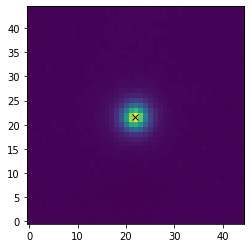

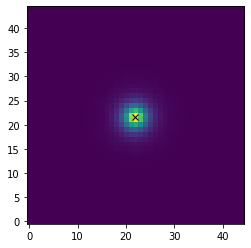

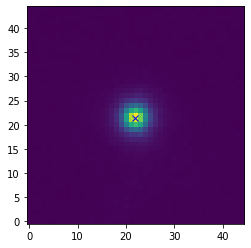

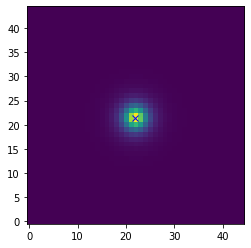

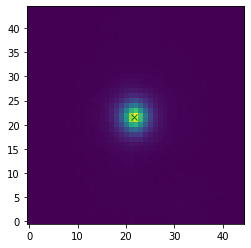

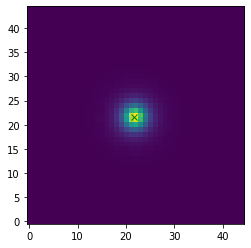

1.6753855
HE1011-0403
1.6753855
22 21
0.2
[7.85921022e-01 2.22211588e+01 2.15637734e+01 8.64871155e-02
 8.39809428e-02 7.62289087e-04 2.29442036e+00 3.39924152e+00
 3.45188438e+00 1.47636575e-01 4.03750989e+00 4.10003740e+00
 1.73978063e-01 1.00991066e+00] [0.01149141 0.01363077 0.0154598  0.00315499 0.00322988 0.00114571
 0.0405242  0.06169236 0.06675365 0.23709428 0.03785376 0.04146281
 0.03566352 0.00239393]
[ 0.6172913  22.29444244 21.54578004  1.0210181 ] [0.00319827 0.01356841 0.0125714  0.00430619]
[ 1.24184685 22.19732    21.49925827  0.95922025] [0.00301855 0.00596258 0.00657022 0.00212415]


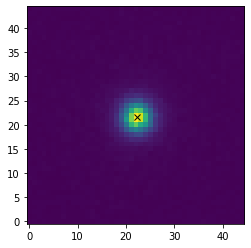

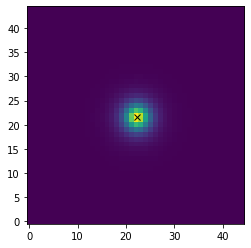

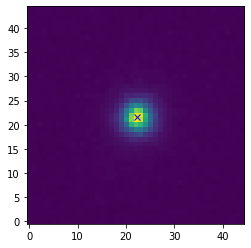

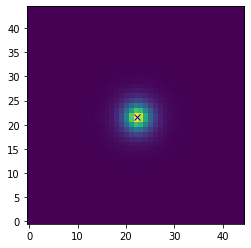

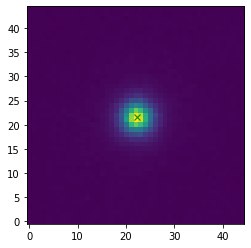

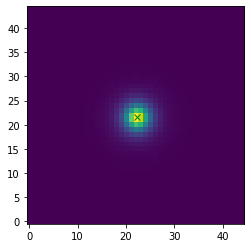

1.5416266
HE1017-0305
1.5416266
22 22
0.2
[ 6.64301318e-01  2.21205610e+01  2.18290180e+01  7.69503244e-02
  7.99260000e-02  5.42010314e-03  2.59742731e+00  3.50220763e+00
  3.64307660e+00 -5.34357829e-01  3.87374227e+00  4.02955544e+00
  2.75390599e-01  1.00146318e+00] [0.00415497 0.00557313 0.00528551 0.00149434 0.00150605 0.00047645
 0.0259549  0.03340678 0.03488503 0.0411547  0.0167454  0.01748299
 0.01043726 0.00079912]
[ 0.49414605 22.14606249 21.76190458  0.90325782] [0.00571134 0.02425902 0.02913915 0.00799395]
[ 1.34368482 22.02366219 21.96104648  1.01943728] [0.00559182 0.00862071 0.00867885 0.00299597]


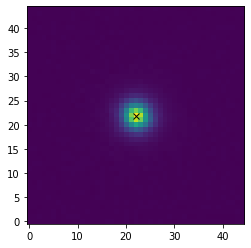

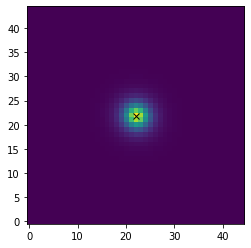

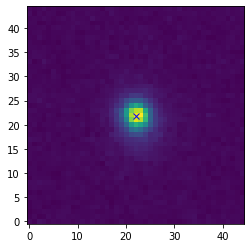

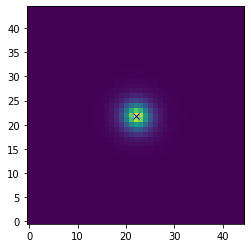

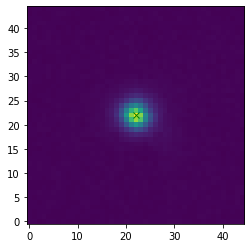

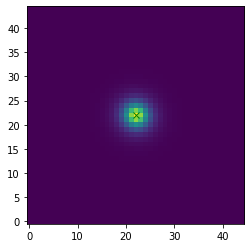

1.5628911
HE1029-1831
1.5628911
22 22
0.2
[ 3.72120695e-01  2.14484265e+01  2.17040649e+01  9.23273419e-02
  9.91074328e-02  8.93608707e-04  2.45803529e+00  3.17601585e+00
  3.29157532e+00 -6.55218128e-02  3.62549461e+00  3.75740839e+00
  2.62645675e-01  1.00079420e+00] [0.00607161 0.02017216 0.01746736 0.00471064 0.00544809 0.00234702
 0.07000833 0.08778917 0.08612796 0.19293191 0.05063371 0.04773866
 0.04694251 0.01097645]
[ 1.69837433 21.22529176 21.98643911  0.93595179] [0.00487171 0.01113019 0.01099384 0.00549251]
[ 0.42592819 21.93371486 21.50051413  0.95321693] [0.00503307 0.01892289 0.0257863  0.01524355]


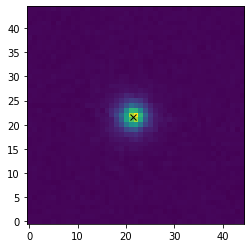

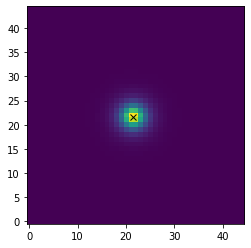

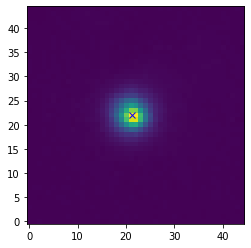

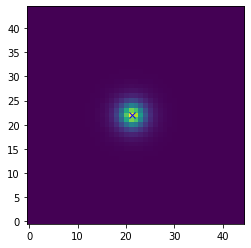

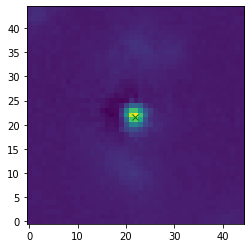

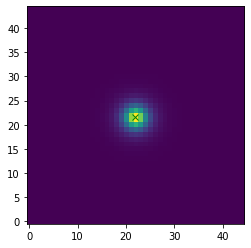

1.3099543
HE1107-0813
1.3099543
22 22
0.2
[ 1.11924446e+00  2.21714370e+01  2.20453200e+01  1.18486864e-01
  1.16725738e-01 -1.90059387e-02  2.44261869e+00  2.80441222e+00
  3.04202130e+00 -7.39199134e-01  3.21288375e+00  3.48510134e+00
  3.87449203e-01  1.01629202e+00] [0.02313782 0.0174735  0.01347097 0.00452306 0.00447255 0.00180405
 0.03634204 0.05331869 0.05820834 0.51853181 0.03697304 0.03984648
 0.01601971 0.00420268]
[ 0.18116592 22.32563482 22.13305535  0.94617135] [0.00361507 0.04408187 0.03865714 0.02085453]
[ 0.64688939 21.19213063 21.6985362   0.53005478] [0.00674752 0.02708179 0.01359294 0.01658043]


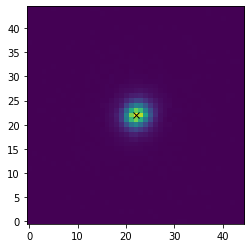

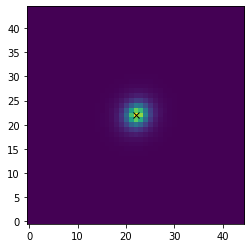

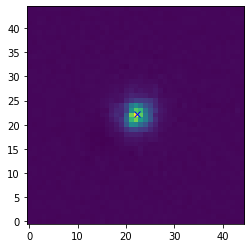

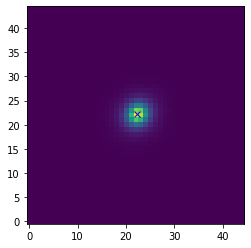

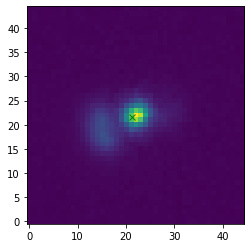

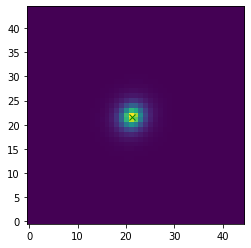

1.7920091
HE1108-2813
1.7920091
22 22
0.2
[1.60347150e+00 2.18028676e+01 2.17669069e+01 2.17702614e-01
 2.02945080e-01 5.14420745e-03 2.43879538e+00 2.14108681e+00
 2.22216936e+00 1.67705400e-01 2.45515083e+00 2.54812692e+00
 2.67665191e-01 1.00176909e+00] [0.01002524 0.00544579 0.00584241 0.00463075 0.00423218 0.00176563
 0.02737938 0.02276763 0.0232367  0.05872081 0.01222864 0.01232957
 0.01312348 0.00112433]
[ 2.36050739 22.15890545 21.80334502  0.99689331] [0.01239345 0.01046113 0.01121921 0.0024857 ]
[ 4.43810659 22.09333653 21.75480938  0.94019134] [0.01223344 0.00635863 0.00553052 0.00136599]


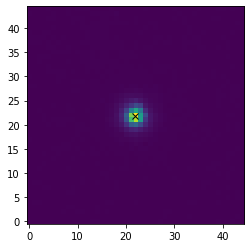

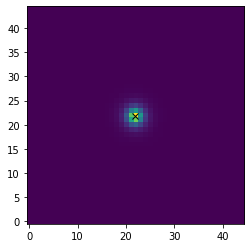

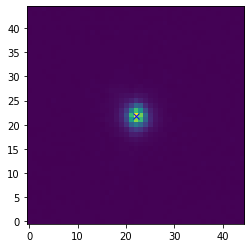

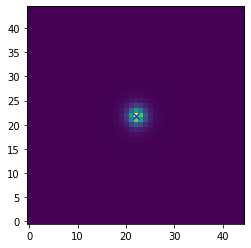

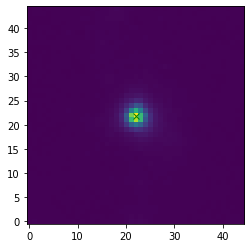

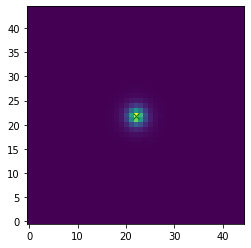

1.4915084
HE1126-0407
1.4915084
23 23
0.2
[ 2.04802176e+00  2.25783695e+01  2.23559909e+01  7.93847897e-02
  8.60081368e-02 -2.48484095e-03  2.45925648e+00  3.40535142e+00
  3.55425631e+00  1.79457194e-01  3.88617870e+00  4.05610859e+00
  2.86416556e-01  1.00512916e+00] [0.01071004 0.00636722 0.00586245 0.00100977 0.00107156 0.00045094
 0.01412831 0.02139755 0.02239263 0.03172125 0.01326325 0.01366316
 0.00757911 0.00127116]
[ 0.59882171 22.67317342 22.3303732   1.0164057 ] [0.00227545 0.00969365 0.00914543 0.00334834]
[ 3.60292956 22.86379024 22.92586869  0.89931329] [0.00305647 0.00183574 0.00274066 0.00065863]


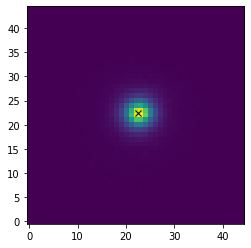

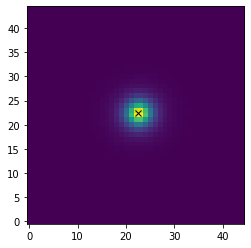

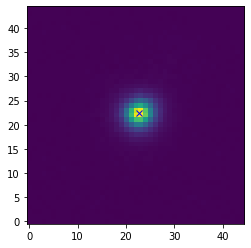

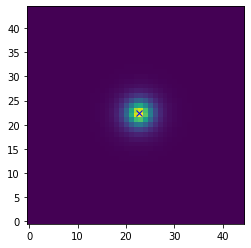

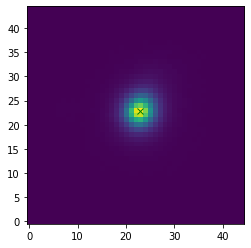

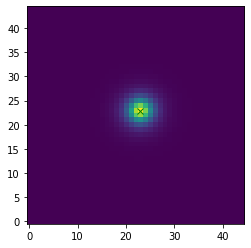

2.2341485
HE1237-0504
2.2341485
22 22
0.2
[ 2.60988645e+00  2.18494220e+01  2.18041521e+01  1.36817202e-01
  1.40039452e-01  6.81328272e-03  2.51368423e+00  2.65188802e+00
  2.72508988e+00 -5.64516536e-01  2.98860975e+00  3.07110637e+00
  2.30223345e-01  9.95365000e-01] [0.00580577 0.00175072 0.00204669 0.00080277 0.00078844 0.00031288
 0.00686765 0.00761935 0.007816   0.02061772 0.0045879  0.0047665
 0.00507987 0.00042833]
[ 2.14984829 21.70720716 21.76957201  0.99183837] [0.00623588 0.00432407 0.00514531 0.00146973]
[16.22798642 22.24716881 21.86303064  0.86589831] [0.00694937 0.00095303 0.00081099 0.00036213]


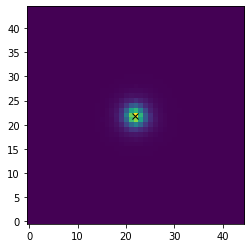

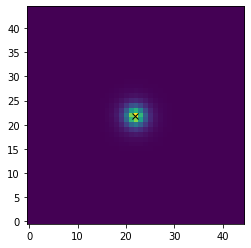

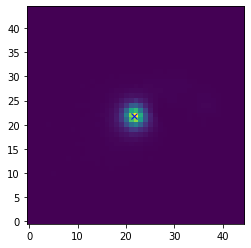

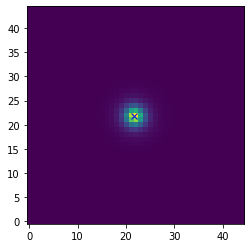

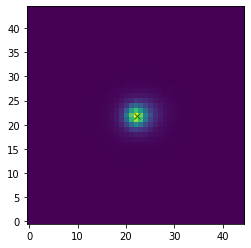

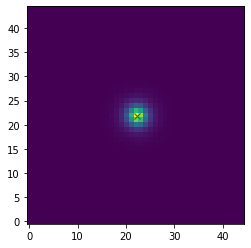

1.5345829
HE1248-1356
1.5345829
22 22
0.2
[ 1.71362909e-01  2.23508958e+01  2.22324319e+01  1.00951944e-01
  8.56846600e-02 -8.62718270e-03  3.47429908e+00  3.12979616e+00
  3.43908312e+00 -2.57172247e-01  2.94134788e+00  3.23201236e+00
  4.14461099e-01  9.99914493e-01] [0.0026535  0.01591772 0.01793232 0.00838645 0.00757185 0.00279118
 0.20493709 0.13073716 0.15292811 0.07446321 0.03784364 0.04889011
 0.0261963  0.00400856]
[ 4.73748946 22.6373646  22.18643722  0.97004931] [0.0122478  0.00509812 0.00497758 0.0113359 ]
[ 0.80407495 22.47728521 22.09084123  1.0300174 ] [0.00395845 0.01118173 0.0111096  0.0033629 ]


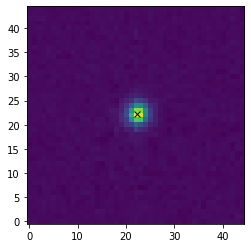

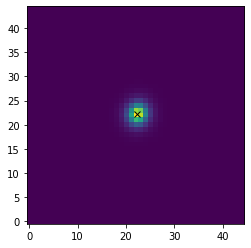

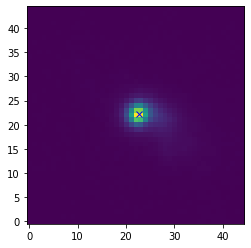

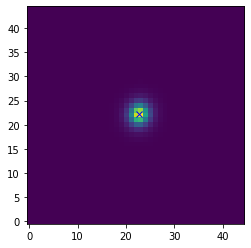

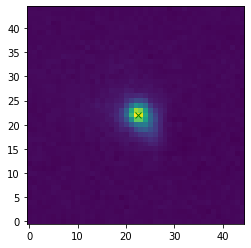

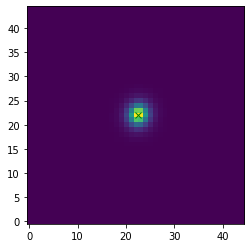

1.5058038
HE1330-1013
1.5058038
22 22
0.2
[ 3.02618565e-01  2.20429215e+01  2.19354532e+01  8.66366151e-02
  9.08316188e-02  4.17506746e-03  2.48380662e+00  3.30240992e+00
  3.41444434e+00 -3.91508155e-01  3.74729810e+00  3.87442538e+00
  2.54061392e-01  1.00177725e+00] [0.00521501 0.02060621 0.02054572 0.00587841 0.00633497 0.00256102
 0.09340596 0.11495671 0.12000033 0.29680599 0.0570131  0.06024705
 0.05086572 0.00375442]
[ 0.17431818 21.94280041 22.12519976  1.00560133] [0.00239791 0.02940818 0.03430198 0.00764192]
[ 0.69979043 22.19401869 21.76115552  0.93903341] [0.00282021 0.01090182 0.01232178 0.00240645]


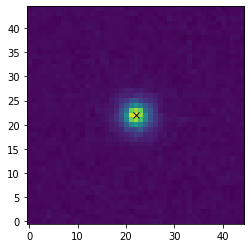

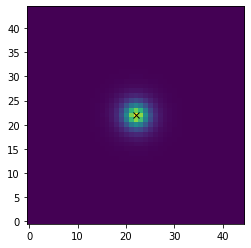

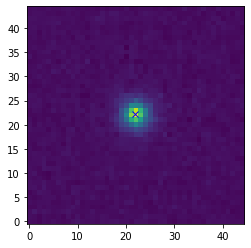

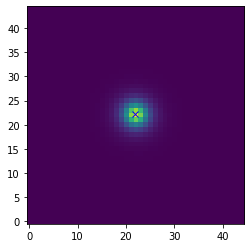

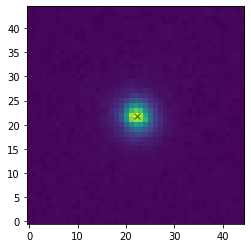

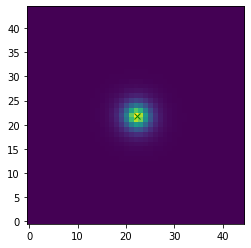

1.4813875
HE1353-1917
1.4813875
22 22
0.2
[ 1.23895076e-01  2.19275836e+01  2.18746807e+01  7.87934670e-02
  8.45551465e-02 -7.49467014e-04  2.47062501e+00  3.43848914e+00
  3.56304897e+00  6.46757917e-02  3.91362834e+00  4.05540015e+00
  2.62098133e-01  1.00270204e+00] [0.00222638 0.01845091 0.0179037  0.00445097 0.00463126 0.00174631
 0.069626   0.09396296 0.10074682 0.16509425 0.05120084 0.05529292
 0.03754331 0.00345604]
[ 0.15259692 25.31741836 17.26257632  1.14879582] [8.49663700e-04 2.70875259e-02 2.95703850e-02 1.33468817e+00]
[ 1.56044568 21.78417878 23.63486772  0.90078988] [0.00444362 0.01209672 0.02136012 0.02279518]


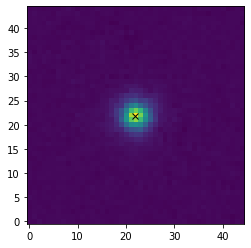

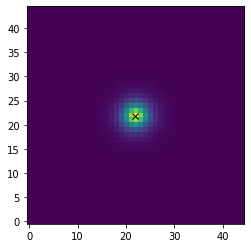

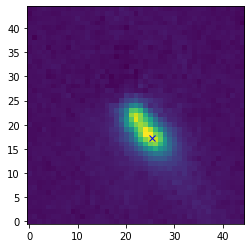

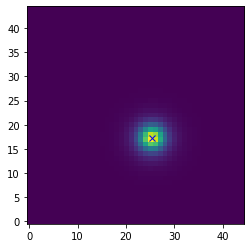

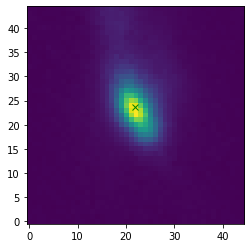

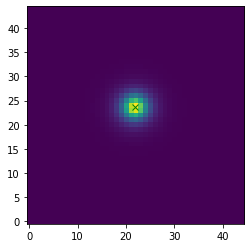

1.4156202
HE1417-0909
1.4156202
22 22
0.2
[ 3.27872166e-01  2.21450893e+01  2.21023739e+01  9.42960996e-02
  9.57341877e-02  7.30550758e-03  2.38413388e+00  3.18242256e+00
  3.30965670e+00 -6.88215787e-01  3.69713625e+00  3.84494879e+00
  2.74606484e-01  1.00345950e+00] [0.00152354 0.00477712 0.00480334 0.00121187 0.00123311 0.00045428
 0.01464433 0.02077433 0.02056003 0.03371334 0.01268785 0.01194582
 0.00741273 0.00090284]
[ 0.57748858 22.31751119 22.02840698  0.95209418] [0.00314654 0.01165685 0.01214505 0.00402061]
[ 2.98839282 22.17483023 22.16279792  0.99550954] [0.00378693 0.0031912  0.00349979 0.00112032]


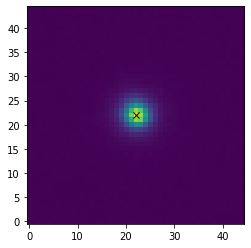

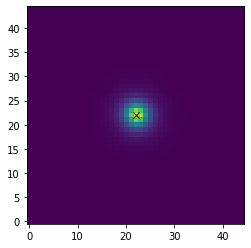

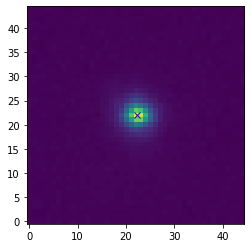

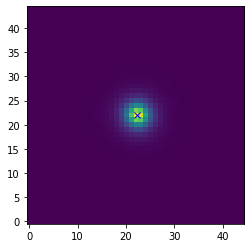

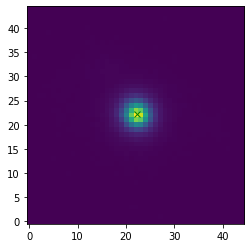

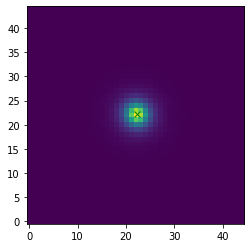

1.6091967
HE2128-0221
1.6091967
22 22
0.2
[1.84706890e-01 2.17027995e+01 2.14147547e+01 9.08787137e-02
 9.03324137e-02 1.07395744e-03 2.47955425e+00 3.31118525e+00
 3.33327584e+00 5.50114654e-01 3.76094691e+00 3.78603809e+00
 1.14937645e-01 1.00530112e+00] [0.00224467 0.01116577 0.01189424 0.00293161 0.00300823 0.00116806
 0.0397178  0.05322292 0.05495805 0.48485336 0.02896858 0.03124173
 0.03398172 0.00244756]
[ 0.41866308 21.69746145 21.6011657   0.96910295] [0.00425514 0.02300911 0.02697398 0.00932172]
[ 1.43269278 21.75707555 21.75789212  0.93090056] [0.00391426 0.00629915 0.00798337 0.0027578 ]


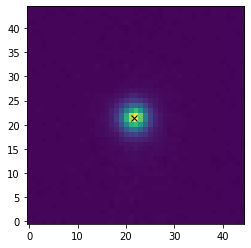

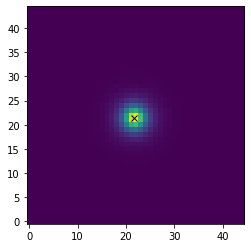

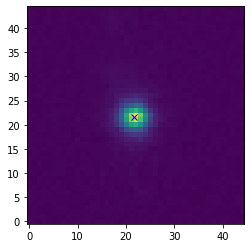

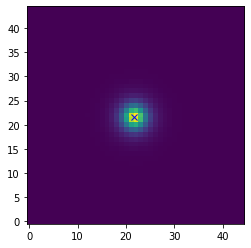

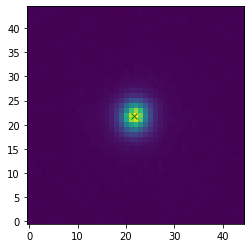

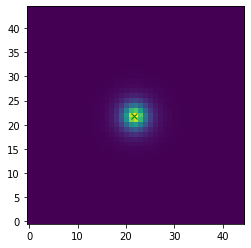

1.8859526
HE2211-3903
1.8859526
22 22
0.2
[ 4.47663963e-01  2.18939121e+01  2.21315130e+01  2.10460508e-01
  1.91649813e-01 -1.17513131e-02  2.41230900e+00  2.17111901e+00
  2.29436656e+00 -2.79196979e-01  2.50526502e+00  2.64748099e+00
  3.23340937e-01  1.00766233e+00] [0.00423088 0.00726222 0.00790385 0.00668858 0.00570099 0.00239828
 0.03863959 0.03432945 0.03437302 0.05239229 0.01935531 0.01842978
 0.01672955 0.00140628]
[ 0.32965517 22.36123079 22.29905733  0.93173765] [0.0088225  0.04449689 0.03786208 0.0114241 ]
[ 4.46402846 21.82644783 22.32699733  0.92005137] [0.0090131  0.00318095 0.0035378  0.00099037]


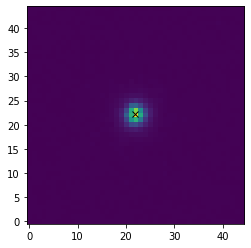

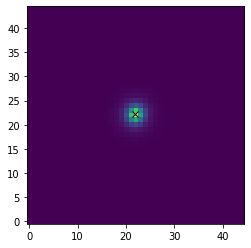

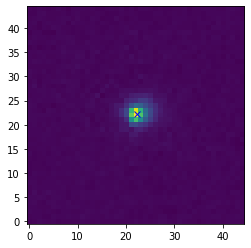

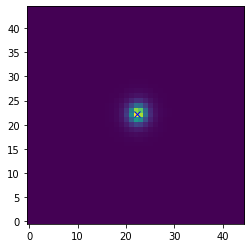

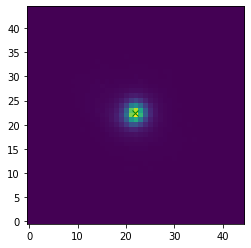

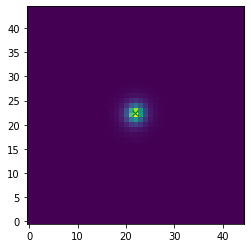

1.7730912
HE2222-0026
1.7730912
22 22
0.2
[ 2.14577677e-01  2.22660464e+01  2.18279953e+01  1.26934049e-01
  1.27743202e-01 -6.79689205e-03  2.26249900e+00  2.76541790e+00
  2.84076944e+00  7.26153276e-01  3.31147016e+00  3.40170042e+00
  2.28793610e-01  9.96477202e-01] [0.00243277 0.01133228 0.01074341 0.00468089 0.00464384 0.00178076
 0.03992773 0.04880562 0.05312071 0.60699004 0.02927246 0.03236438
 0.02846526 0.00225546]
[ 0.10180139 22.4584045  21.87555194  0.99423426] [0.00175364 0.03820895 0.04315262 0.01335722]
[ 0.4714659  22.25850117 21.86041105  0.96977219] [0.00177213 0.0072534  0.00699625 0.00194952]


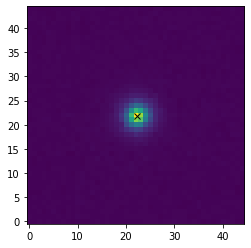

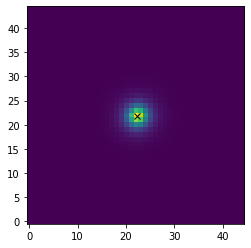

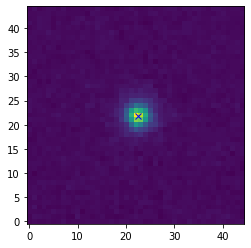

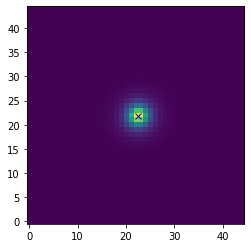

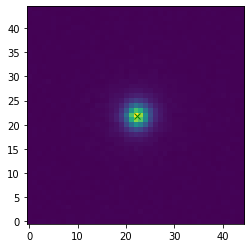

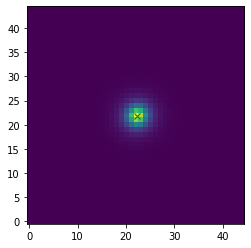

1.4704366
HE2233+0124
1.4704366
22 22
0.2
[ 4.17258009e-02  2.18062317e+01  2.21470314e+01  5.92116802e-02
  5.80274325e-02 -6.75319851e-03  2.67237509e+00  4.01455327e+00
  4.25661300e+00 -6.98600199e-01  4.36918945e+00  4.63263216e+00
  3.32414895e-01  1.01068146e+00] [0.00079159 0.01901815 0.02694912 0.00473762 0.00461464 0.00151229
 0.13069944 0.16593335 0.17520115 0.50829854 0.07167137 0.07498307
 0.03226076 0.00434432]
[ 0.02550347 21.95229286 22.22995471  1.01886962] [0.00065126 0.07354631 0.06687767 0.01774974]
[ 0.18222024 21.77623498 22.12868943  0.96142302] [0.00069483 0.01035337 0.01402204 0.00244793]


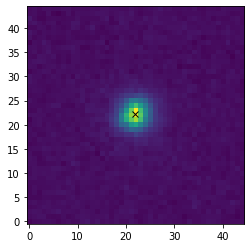

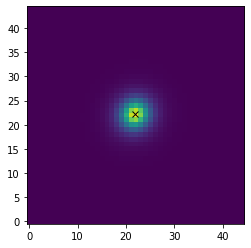

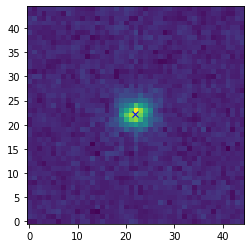

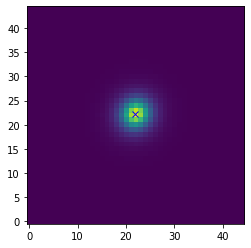

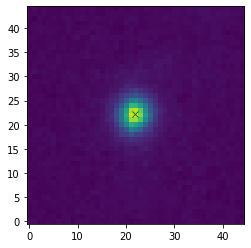

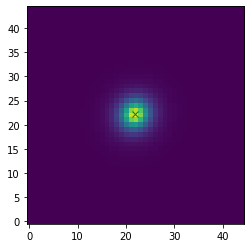

1.7490312
HE2302-0857
1.7490312
21 22
0.2
[ 9.30496124e-01  2.18946931e+01  2.18112534e+01  1.04893660e-01
  1.07244024e-01  2.31031887e-03  2.32758810e+00  3.04690192e+00
  3.09461136e+00 -3.88403159e-01  3.58907680e+00  3.64527580e+00
  1.74917698e-01  9.98733256e-01] [0.02141904 0.01389699 0.01161598 0.00345383 0.00383622 0.00097215
 0.02812999 0.05495893 0.05140605 0.20020159 0.04266109 0.03844431
 0.03156231 0.00321312]
[ 1.08094532 22.83839835 22.01238558  1.23912229] [0.00857792 0.02028426 0.0194086  0.02290369]
[14.19274557 21.14838383 21.59110069  0.82086992] [0.01334293 0.00256698 0.00161958 0.00196692]


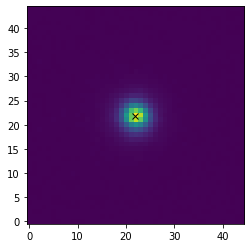

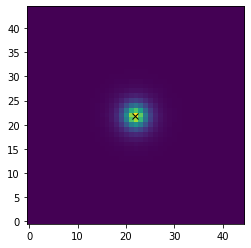

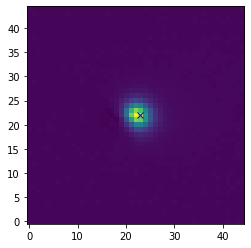

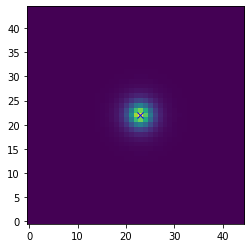

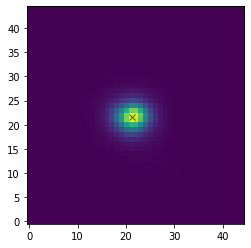

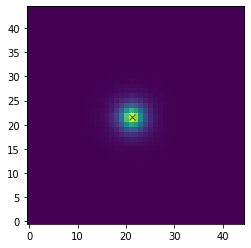

In [13]:
z = {"HE0021-1819":0.053197,"HE0040-1105":0.041692,"HE0108-4743":0.02392,"HE0114-0015":0.04560
    ,"HE0119-0118":0.054341,"HE0212-0059":0.026385,"HE0224-2834":0.059800,"HE0227-0913":0.016451,"HE0232-0900":0.043143
    ,"HE0253-1641":0.031588,"HE0345+0056":0.031,"HE0351+0240":0.036,"HE0412-0803":0.038160,"HE0429-0247":0.042009
    ,"HE0433-1028":0.035550,"HE0853+0102":0.052,"HE0934+0119":0.050338,"HE1011-0403":0.058314,"HE1017-0305":0.049986
    ,"HE1029-1831":0.040261,"HE1107-0813":0.058,"HE1108-2813":0.024013,"HE1126-0407":0.061960,"HE1237-0504":0.009
    ,"HE1248-1356":0.01465,"HE1330-1013":0.022145,"HE1353-1917":0.035021,"HE1417-0909":0.044,"HE2128-0221":0.05248
    ,"HE2211-3903":0.039714,"HE2222-0026":0.059114,"HE2233+0124":0.056482,"HE2302-0857":0.046860}


objs = z.keys()

for obj in objs:
    (Hb_blr_br_data,OIII_br_data,OIII_nr_data,amp_Hb_blr_br,amp_OIII_br,amp_OIII_nr,Hb_blr_br_err,OIII_br_err,OIII_nr_err) = flux_data_err(obj)
    box_size = np.shape(Hb_blr_br_data)[1]  
    y, x = np.mgrid[:box_size, :box_size]
    xy=(x,y)
    algorithm_script(obj,z[obj])

1.2495849
HE0021-1810
1.2495849
22 22
0.2
[ 2.55837387e-02  2.19115104e+01  2.25162231e+01  3.36797853e-02
  3.69143816e-02  3.64036208e-03  3.70515208e+00  5.14807912e+00
  5.51634929e+00 -4.22175306e-01  4.66995893e+00  5.00402655e+00
  3.59252918e-01  1.03070909e+00] [2.96347252e-03 1.24285376e-01 8.69688628e-02 1.42497547e-02
 1.69202750e-02 2.89171247e-03 3.17809846e+00 1.98460752e+00
 2.15090744e+00 3.78834102e-01 3.72212957e-01 4.01076075e-01
 1.03059233e-01 4.66569382e+17]
[ 0.23324406 21.99236223 22.34122318  1.01431449] [1.28500951e-03 1.34334133e-02 1.20817803e-02 1.37304830e+14]
[ 0.36332332 22.04131391 22.34318131  1.00886407] [1.93801279e-03 1.19820326e-02 1.19029434e-02 7.19782543e+13]


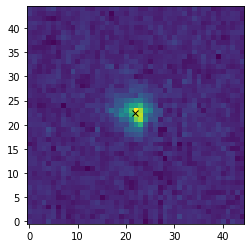

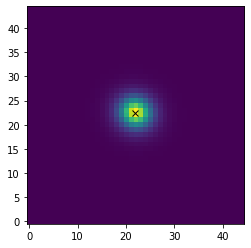

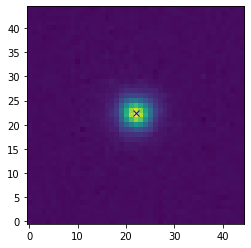

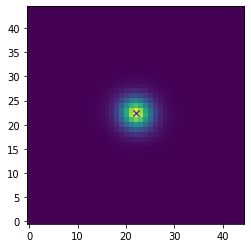

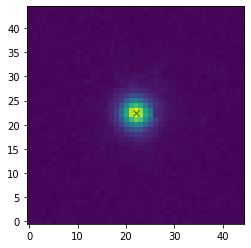

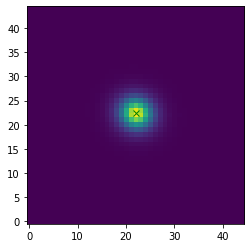

In [14]:
z = {"HE0021-1810":0.05352}

objs = z.keys()

for obj in objs:
    (Hb_blr_br_data,OIII_br_data,OIII_nr_data,amp_Hb_blr_br,amp_OIII_br,amp_OIII_nr,Hb_blr_br_err,OIII_br_err,OIII_nr_err) = flux_data_err(obj)
    box_size = np.shape(Hb_blr_br_data)[1]  
    y, x = np.mgrid[:box_size, :box_size]
    xy=(x,y)
    algorithm_script(obj,z[obj])